# Multi-Class Classification

For this exercise we'll use logistic regression to recognize hand-written digits (0 to 9).  We'll be extending the implementation of logistic regression we wrote in our previous exercise and apply it to one-vs-all classification.  Let's get started by loading the data set.  It's in MATLAB's native format, so to load it in Python we need to use a SciPy utility.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.io import loadmat
%matplotlib inline

In [2]:
data = loadmat(r"C:\Users\Suwani Gunasekara\OneDrive\Documents\Sem 7 ML\ex3data1.mat")
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [3]:
data['X'].shape, data['y'].shape

((5000, 400), (5000, 1))

Great, we've got our data loaded.  The images are represented in martix X as a 400-dimensional vector (of which there are 5,000 of them).  The 400 "features" are grayscale intensities of each pixel in the original 20 x 20 image.  The class labels are in the vector y as a numeric class representing the digit that's in the image.There's an illustration below gives an example of what some of the digits look like. Each grey box with a white hand-drawn digit represents on 400-dimensional row in our dataset.

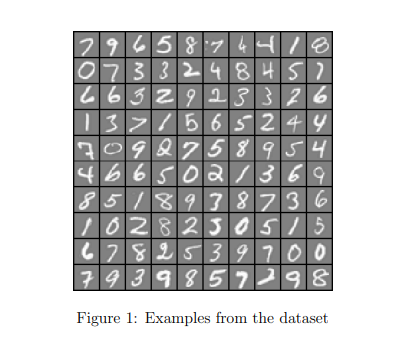

If you feel adventurous above image can be recreated by using the following code snippet as well.

import matplotlib.image as mpimg
fig, axis = plt.subplots(10,10,figsize=(8,8))
for i in range(10):
    for j in range(10):
        axis[i,j].imshow(X[np.random.randint(0,5001),:].reshape(20,20,order="F"), cmap="hot") #reshape back to 20 pixel by 20 pixel
        axis[i,j].axis("off")


The first task is to modify our logistic regression implementation to be completely vectorized (i.e. no "for" loops).  This is because vectorized code, in addition to being short and concise, is able to take advantage of linear algebra optimizations and is typically much faster than iterative code.  However if you look at our cost function implementation from our previous exercise, it's already vectorized!  So we can re-use the same implementation here.  Note we're skipping straight to the final, regularized version.

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [5]:
def cost(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    reg = (learningRate / 2 * len(X)) * np.sum(np.power(theta[:,1:theta.shape[1]], 2))
    return np.sum(first - second) / (len(X)) + reg

Next we need the function that computes the gradient.  Again, we already defined this in the previous exercise, only in this case we do have a "for" loop in the update step that we need to get rid of.  Here's the original code for reference:

In [6]:
def gradient_with_loop(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)
    
    error = sigmoid(X * theta.T) - y
    
    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        
        if (i == 0):
            grad[i] = np.sum(term) / len(X)
        else:
            grad[i] = (np.sum(term) / len(X)) + ((learningRate / len(X)) * theta[:,i])
    
    return grad

In our new version we're going to pull out the "for" loop and compute the gradient for each parameter at once using linear algebra (except for the intercept parameter, which is not regularized so it's computed separately).

Also note that we're converting the data structures to NumPy matrices (which I've used for the most part throughout these exercises).

In [7]:
def gradient(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(theta.ravel().shape[1])
    error = sigmoid(X * theta.T) - y
    
    grad = ((X.T * error) / len(X)).T + ((learningRate / len(X)) * theta)
    
    # intercept gradient is not regularized
    grad[0, 0] = np.sum(np.multiply(error, X[:,0])) / len(X)
    
    return np.array(grad).ravel()

Now that we've defined our cost and gradient functions, it's time to build a classifier.  For this task we've got 10 possible classes, and since logistic regression is only able to distiguish between 2 classes at a time, we need a strategy to deal with the multi-class scenario.  In this exercise we're tasked with implementing a one-vs-all classification approach, where a label with k different classes results in k classifiers, each one deciding between "class i" and "not class i" (i.e. any class other than i).  We're going to wrap the classifier training up in one function that computes the final weights for each of the 10 classifiers and returns the weights as a k X (n + 1) array, where n is the number of parameters.

In [8]:
from scipy.optimize import minimize

def one_vs_all(X, y, num_labels, learning_rate):
    rows = X.shape[0]
    params = X.shape[1]
    
    # k X (n + 1) array for the parameters of each of the k classifiers
    all_theta = np.zeros((num_labels, params + 1))
    
    # insert a column of ones at the beginning for the intercept term
    X = np.insert(X, 0, values=np.ones(rows), axis=1)
    
    # labels are 1-indexed instead of 0-indexed
    for i in range(1, num_labels + 1):
        theta = np.zeros(params + 1)
        y_i = np.array([1 if label == i else 0 for label in y])
        y_i = np.reshape(y_i, (rows, 1))
        
        # minimize the objective function
        fmin = minimize(fun=cost, x0=theta, args=(X, y_i, learning_rate), method='TNC', jac=gradient)
        all_theta[i-1,:] = fmin.x
    
    return all_theta

A few things to note here...first, we're adding an extra parameter to theta (along with a column of ones to the training data) to account for the intercept term.  Second, we're transforming y from a class label to a binary value for each classifier (either is class i or is not class i).  Finally, we're using SciPy's newer optimization API to minimize the cost function for each classifier.  The API takes an objective function, an initial set of parameters, an optimization method, and a jacobian (gradient) function if specified.  The parameters found by the optimization routine are then assigned to the parameter array.

One of the more challenging parts of implementing vectorized code is getting all of the matrix interactions written correctly, so I find it useful to do some sanity checks by looking at the shapes of the arrays/matrices I'm working with and convincing myself that they're sensible.  Let's look at some of the data structures used in the above function.

In [9]:
rows = data['X'].shape[0]
params = data['X'].shape[1]

all_theta = np.zeros((10, params + 1))

X = np.insert(data['X'], 0, values=np.ones(rows), axis=1)

theta = np.zeros(params + 1)

y_0 = np.array([1 if label == 0 else 0 for label in data['y']])
y_0 = np.reshape(y_0, (rows, 1))

X.shape, y_0.shape, theta.shape, all_theta.shape

((5000, 401), (5000, 1), (401,), (10, 401))

These all appear to make sense.  Note that theta is a one-dimensional array, so when it gets converted to a matrix in the code that computes the gradient, it turns into a (1 X 401) matrix.  Let's also check the class labels in y to make sure they look like what we're expecting.

In [10]:
np.unique(data['y'])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

Let's make sure that our training function actually runs, and we get some sensible outputs, before going any further.

In [11]:
all_theta = one_vs_all(data['X'], data['y'], 10, 1)
all_theta

array([[-3.70247926e-05,  0.00000000e+00,  0.00000000e+00, ...,
        -2.24803608e-10,  2.31962906e-11,  0.00000000e+00],
       [-8.96250666e-05,  0.00000000e+00,  0.00000000e+00, ...,
         7.26120759e-09, -6.19965241e-10,  0.00000000e+00],
       [-8.39553327e-05,  0.00000000e+00,  0.00000000e+00, ...,
        -7.61695557e-10,  4.64917621e-11,  0.00000000e+00],
       ...,
       [-7.00832477e-05,  0.00000000e+00,  0.00000000e+00, ...,
        -6.92009077e-10,  4.29241521e-11,  0.00000000e+00],
       [-7.65188037e-05,  0.00000000e+00,  0.00000000e+00, ...,
        -8.09503443e-10,  5.31058807e-11,  0.00000000e+00],
       [-6.63412331e-05,  0.00000000e+00,  0.00000000e+00, ...,
        -3.49765821e-09,  1.13668504e-10,  0.00000000e+00]])

We're now ready for the final step - using the trained classifiers to predict a label for each image.  For this step we're going to compute the class probability for each class, for each training instance (using vectorized code of course!) and assign the output class label as the class with the highest probability.

In [12]:
def predict_all(X, all_theta):
    rows = X.shape[0]
    params = X.shape[1]
    num_labels = all_theta.shape[0]
    
    # same as before, insert ones to match the shape
    X = np.insert(X, 0, values=np.ones(rows), axis=1)
    
    # convert to matrices
    X = np.matrix(X)
    all_theta = np.matrix(all_theta)
    
    # compute the class probability for each class on each training instance
    h = sigmoid(X * all_theta.T)
    
    # create array of the index with the maximum probability
    h_argmax = np.argmax(h, axis=1)
    
    # because our array was zero-indexed we need to add one for the true label prediction
    h_argmax = h_argmax + 1
    
    return h_argmax

Now we can use the predict_all function to generate class predictions for each instance and see how well our classifier works.

In [14]:
y_pred = predict_all(data['X'], all_theta)
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, data['y'])]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print(accuracy * 100)

74.6


Almost 98% isn't too bad!  That's all for this exercise.